# Suivi de l'apprentissage dans KERAS: utilisation de métriques spécifiques


Keras offre la possibilité de spécifier différentes métriques pour suivre l'évolution des performances de prédiction (sur le jeu d'apprentissage ou sur un jeu de validation) lors de l'apprentissage.

Pour cela il suffit de spécifier l'arguments **"metrics"** lors de l'étape de compilation du modèle (via la fonction **compile()**)


Dans ce notebook nous allons illustrer l'utilisation de telles métriques lors de l'apprentissage de modèles.
Nous travaillerons pour cela sur le même jeu de données que celui du TP précédent, le jeu MNIST, et nous utiliserons un perceptron multi-couches "standard".

Pour illustrer l'utilisation de plusieurs métriques, nous considèrerons un problème binaire et suivrons simultanément l'évolution de l'**accuracy** et de l'**AUC**.

**Précision importante** : ce notebook n'est valable que pour **tensorflow v2**, qui permet d'utiliser davantage de métriques (voir ici: https://www.tensorflow.org/api_docs/python/tf/keras/metrics pour toutes les métriques disponibles).

## On commence par importer les packages & fonctions nécessaires

In [1]:
# import packages
import csv
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

# set random seed
np.random.seed(123)

## On met enuite en forme le jeu de données.

Pour cela : 
* on le charge via la fonction disponible dans Keras
* on ramène l'intensité des images dans la gamme \[0,1\]
* on convertit les images 28x28 en vecteurs (de longueur 28x28 = 784).

In [2]:
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print('size of training data: ')
print(X_train.shape)
print('size of test data: ')
print(X_test.shape)

# convert our data type to float32 and normalize our data values to the range [0, 1]
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# cast to vector
input_dim = 28*28 
X_train_vec = X_train.reshape(60000, input_dim) 
X_test_vec  = X_test.reshape(10000, input_dim)

size of training data: 
(60000, 28, 28)
size of test data: 
(10000, 28, 28)


## On crée ensuite un problème de classification binaire

Pour cela, nous considèrerons le problème visant à reconnaître le caractère "0" des autres caractères.

In [3]:
# create binary outcome
y_train_0 = np.zeros(y_train.shape)
y_train_0[y_train == 0] = 1

## On sépare enfin les données d'apprentissage en données d'apprentissage et de validation


In [4]:
from sklearn.model_selection import train_test_split
X_train_vec_train, X_train_vec_val, y_train_0_train, y_train_0_val = train_test_split(X_train_vec, y_train_0, test_size=0.2, random_state=42)

## On définit un modèle de perceptron multi-couches

In [5]:
# create model
mlp = Sequential()
mlp.add(Dense(64, activation='relu', input_dim=input_dim))
mlp.add(Dense(100, activation='relu'))
mlp.add(Dense(1, activation='sigmoid'))

## On compile le modèle en spécifiant de suivre à la fois les métriques d'accuracy et d'AUC

In [6]:
mlp.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy','AUC']) 

## On fitte le modèle

On en profite pour créer un callbak "CSV logger" pour stocker l'évolution des performances dans un fichier texte pour en garder la trace.


In [7]:
# define "csv logger" callback
from tensorflow.keras.callbacks import CSVLogger
csv_logger = CSVLogger("./Illustration-metrics/training-log.csv")
# create output dir
if not os.path.exists("./Illustration-metrics"):
    os.mkdir("./Illustration-metrics")
# fit model with standard SGD
history_mlp = mlp.fit(X_train_vec_train, y_train_0_train, 
        validation_data = (X_train_vec_val,y_train_0_val),
        batch_size=32, epochs=10, verbose=1, callbacks = csv_logger)

Epoch 1/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0988 - accuracy: 0.9706 - auc: 0.9787 - val_loss: 0.0453 - val_accuracy: 0.9887 - val_auc: 0.9906
Epoch 2/10
1500/1500 [==============================] - 2s 2ms/step - loss: 0.0371 - accuracy: 0.9901 - auc: 0.9936 - val_loss: 0.0348 - val_accuracy: 0.9905 - val_auc: 0.9930
Epoch 3/10
1500/1500 [==============================] - 2s 2ms/step - loss: 0.0300 - accuracy: 0.9916 - auc: 0.9954 - val_loss: 0.0305 - val_accuracy: 0.9921 - val_auc: 0.9931
Epoch 4/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0262 - accuracy: 0.9926 - auc: 0.9963 - val_loss: 0.0278 - val_accuracy: 0.9929 - val_auc: 0.9939
Epoch 5/10
1500/1500 [==============================] - 2s 2ms/step - loss: 0.0236 - accuracy: 0.9933 - auc: 0.9967 - val_loss: 0.0256 - val_accuracy: 0.9926 - val_auc: 0.9953
Epoch 6/10
1500/1500 [==============================] - 2s 2ms/step - loss: 0.0219 - accuracy: 0.9937 - auc: 0.9969 - va

## Enfin, on représente l'évolution des deux métriques considérées, ainsi que celle de la fonction de perte

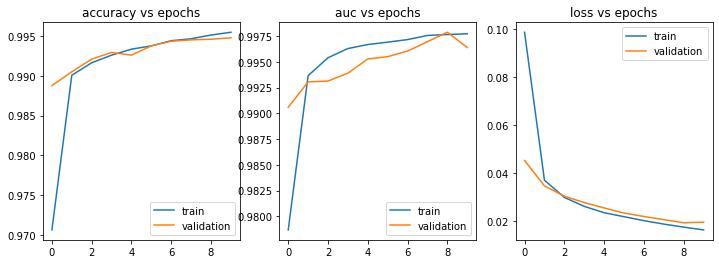

In [8]:
plt.figure(figsize=(12,4))
# show accuracy
plt.subplot(1,3,1)
plt.plot(history_mlp.history['accuracy'], label = 'train')
plt.plot(history_mlp.history['val_accuracy'], label = 'validation')
plt.title("accuracy vs epochs")
plt.legend()
# show accuracy
plt.subplot(1,3,2)
plt.plot(history_mlp.history['auc'], label = 'train')
plt.plot(history_mlp.history['val_auc'], label = 'validation')
plt.title("auc vs epochs")
plt.legend()
# show loss
plt.subplot(1,3,3)
plt.plot(history_mlp.history['loss'], label = 'train')
plt.plot(history_mlp.history['val_loss'], label = 'validation')
plt.title("loss vs epochs")
plt.legend()
plt.show()

# Pour aller plus loin...

Pour aller plus loin, se référer à la documentation de Keras : https://www.tensorflow.org/api_docs/python/tf/keras/metrics/ 

Vous verrez que de nombreuses métriques sont disponibles, et qu'il est même possible de définir votre propre métrique !